$d=As+n$

$n=d-As$

Assuming Gaussian noise, with the covariance matrix : $N=\langle nn^T\rangle$.

We define likelihood : $$\mathcal{S}\equiv-2ln(\mathcal{L})=n^TN^{-1}n$$

$S = (d-As)^TN^{-1}(d-As)$

$\frac{\partial \mathcal{S}}{\partial s} = -2A^TN^{-1}d+2A^TN^{-1}As$ yielding $s_{max}=(A^TN^{-1}A)^{-1}A^TN^{-1}d$

Replacing in the definition of the likelihood : 
$$\mathcal{S}_{spec}=\sum_p(C-d_p^TN^{-1}A(A^TN^{-1}A)^{-1}A^TN^{-1}d_p)$$

$H^2=\frac{8\pi G}{3}\rho$ with $\rho = \frac{1}{2}\dot{\phi}^2+V(\phi)$

Equivalently, $H^{-1}=(\frac{3}{8\pi G\rho})^{\frac{1}{2}}$

Thus $\epsilon \equiv -\frac{\dot{H}}{H^2}= \frac{dH^{-1}}{dt}$

$\epsilon = \sqrt{\frac{3}{8\pi G}}[-\frac{1}{2}\frac{\dot{\rho}}{\rho^{\frac{3}{2}}}]$

## Transmittance

Fit oblique
$(n,\tan \delta, d,f_{in},\theta_{i},pol_{inc}) $
$\sqrt{\frac{\epsilon_0}{\mu_0}}$
$n_i\sin (\theta_i) = n_{i+1}\sin (\theta_{i+1})$
$\underline{n_i}=n_i - 0.5n_i\tan \delta_i$
Effective thickness
$h_i = n_{i+1}*d_i*\cos \theta_{i+1}$
$k\equiv \frac{2\pi f}{c}=\frac{\omega}{c}$
If $pol_{inc}=1$:


$\Upsilon_i = \sqrt{\frac{\epsilon_0}{\mu_0}} \underline{n_i}\cos(\theta_i)$ and $CC=1$
If $pol_{inc}=-1$:

$\Upsilon_i = \sqrt{\frac{\epsilon_0}{\mu_0}}\frac{ \underline{n_i}}{\cos(\theta_i)}$ and $CC=\frac{\cos \theta_{i+1}}{\cos(\theta_0)}$
$$ \mathcal{M} = \Pi_{i=0}^n\mathcal{M_i}
$$ 
with
$$\mathcal{M_i}=
\left(\begin{array}{cc} 
\cos (kh_i) & \cos (kh_i) \Upsilon_i\\
\sin (kh_i)/\Upsilon_i & \cos (kh_i)
\end{array}\right)$$
$r = \frac{\Upsilon_0 m_{11} + \Upsilon_0 \Upsilon_s m_{12} -m_{21}-\Upsilon_s m_{22}}{\Upsilon_0 m_{11} + \Upsilon_0 \Upsilon_s m_{12}+m_{21}+\Upsilon_s m_{22}}$ and 
$r = \frac{2\Upsilon_0 }{\Upsilon_0 m_{11} + \Upsilon_0 \Upsilon_s m_{12}+m_{21}+\Upsilon_s m_{22}}$
With $r=\frac{E_{rI}}{E_{iI}}$ and $t=\frac{E_{tII}}{E_{iI}}$

def fit_oblique_basic_multilayer_r_t_incloss( n, losstan, d, freq_in, angle_i, incpol):

    num=len(d) #; the number of layer not including two ends
    const = np.sqrt((8.85e-12)/(4.*pi*1e-7)) #SI unit sqrt(dielectric const/permiability)

    # ;-----------------------------------------------------------------------------------
    # ; angle of refraction
    angle = np.zeros(num+2)          # ; angle[0]=incident angle
    angle[0] = angle_i
    for i in range(0,num+1): angle[i+1] = np.arcsin(np.sin(angle[i])*n[i]/n[i+1])

    # ;-----------------------------------------------------------------------------------
    # ; define the frequency span
    l = len(freq_in)
    output = np.zeros((3,l),'complex') # output = dcomplexarr(3,l)
    
    # ;-----------------------------------------------------------------------------------
    # ; define the effective thickness of each layer
    h = np.zeros(num,'complex')
    n_comparr = np.zeros(len(n),'complex')
    n_comparr[0] = complex(n[0], -0.5*n[0]*losstan[0])
    n_comparr[num+1] = complex(n[num+1], -0.5*n[num+1]*losstan[num+1])

    # ;-----------------------------------------------------------------------------------
    # ; for loop for various thickness of air gap between each layer
    for j in range(0,l):
        for i in range(0,num): 
            n_comparr[i+1] = complex(n[i+1], -0.5*n[i+1]*losstan[i+1])
            h[i] = n_comparr[i+1]*d[i]*np.cos(angle[i+1]) # ;effective thickness of 1st layer

        freq = freq_in[j]
        k = 2.*pi*freq/c
        
        # ;===========================================
        # ; Y: Y[0]=vacuum, Y[1]=1st layer..., Y[num+1]=end side
        Y = np.zeros(num+2,'complex')
        for i in range(0,num+2):
            if (incpol == 1):
                Y[i] = const*n_comparr[i]*np.cos(angle[i])
                cc = 1.
            if (incpol == -1):
                Y[i] = const*n_comparr[i]/np.cos(angle[i])
                cc = np.cos(angle[num+1])/np.cos(angle[0])

        # ;===========================================
        # ; define matrix for single layer
        m = np.identity((2),'complex')    # ; net matrix
        me = np.zeros((2,2),'complex') # ; me[0]=1st layer, ...
        for i in range(0,num):
            me[0,0] = complex(np.cos(k*h[i]), 0.)
            me[1,0] = complex(0., np.sin(k*h[i])/Y[i+1])
            me[0,1] = complex(0., np.sin(k*h[i])*Y[i+1])
            me[1,1] = complex(np.cos(k*h[i]), 0.)
            m = np.dot(m,me)

        r = (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]-m[0,1]*cc-Y[num+1]*m[1,1]) / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])
        t = 2.*Y[0] / (Y[0]*m[0,0]*cc+Y[0]*Y[num+1]*m[1,0]+m[0,1]*cc+Y[num+1]*m[1,1])

        output[0,j] = freq+0.j #; unit of [Hz]
        output[1,j] = r
        output[2,j] = t

    return output

We measure $T_{meas}=\hat{T}+\delta T_{sys} + n$ where $\hat{T}$ is the true signal, $\delta T_{sys}$ is to be determined and $n$ is assumed to be a Gaussian white noise.

From the data, we can fit our transmittance model and retrieve $T_{fit}$.

We then define the residuals $\Delta T \equiv  T_{meas}-T_{fit}$.

We then compute the Power Spectrum Density of the residuals.

\textit{Preliminary :}

If $X(t)$ is a real signal, we denote its Fourier transform $\tilde{X}(\nu)\equiv \int_{-\infty}^{+\infty}x(t) e^{i\nu t}dt$.

We can discretize this integral and we denote $x_i , i \in [[-N/2,N/2]]$

The PSD is defined element-wise by $|x_i|^2+|x_{-i}|^2$
We remove the systematic peaks by assuming the residual PSD to be a Gaussian in a first approximation and compute its mean $\mu$ and width $\sigma$. Now, we remove the peaks that are oustide of an uncertainty range, of which we define the level. This gives us $P^{notched}$ the notched PSD.
From the notched PSD, we compute the notched residual $\Delta T_n$.
Then, $\Delta T -\Delta T_n = \delta T$, which should account for all the systematics. 
Eventually, we use $T_{clean}=T_{meas}-\delta T$ as our data to fit and hope for a better result.

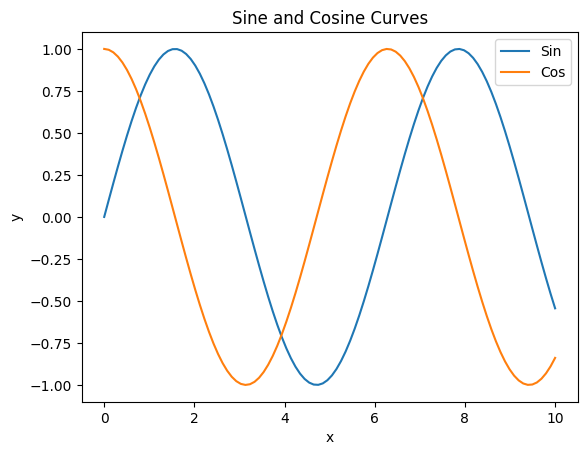

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Plot the data with labels
plt.plot(x, y1, label='Sin')
plt.plot(x, y2, label='Cos')

# Add a legend
plt.legend()

# Add axis labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine and Cosine Curves')

# Show the plot
plt.show()


In [3]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import cmbdb as cmb
from fgbuster import *

In [4]:
NSIDE = 64
sky_simple = get_sky(NSIDE, 'c1d0s0') 
instrument = get_instrument('LiteBIRD')
map_100GHz = sky_simple.get_emission(100 * u.GHz)
print(map_100GHz.shape)


(3, 49152)


In [13]:
map_100GHz[1].size/(NSIDE*NSIDE)


12.0

In [6]:
fwhm = instrument.fwhm
freq = instrument.frequency
num_freq = np.size(freq)
print(fwhm.shape)
print(num_freq)


(15,)
15


In [21]:
fwhm.shape
beam_array = np.array([hp.gauss_beam(f) for f in fwhm])
print(beam_array.shape, freq.shape)

(15, 513) (15,)


In [25]:
b_l_arr= np.array([hp.beam2bl(beam_array[i],lmax = 512) for i in range(0,num_freq)])
print(b_l_arr.shape)

TypeError: beam2bl() missing 1 required positional argument: 'theta'

In [9]:
AS_lm = hp.map2alm(map_100GHz)
AS_lm.shape

(3, 18528)

$\hat{d}_p=(B\star As)_p$